In [2]:
# Step 1: Install and import necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer


# Marketing Campaign Response Prediction

In [3]:
# Step 2: Load the dataset
from google.colab import files
uploaded = files.upload()

Saving marketing_campaign.csv to marketing_campaign.csv


In [4]:
# Read the CSV file
df = pd.read_csv('marketing_campaign.csv', sep=';')

In [5]:
# Step 3: Exploratory Data Analysis (EDA)
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (2240, 29)

First 5 rows:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   
2  2013-08-21       26       426  ...                  4             0   
3  2014-02-10       26        11  ...                  6             0   
4  2014-01-19       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  

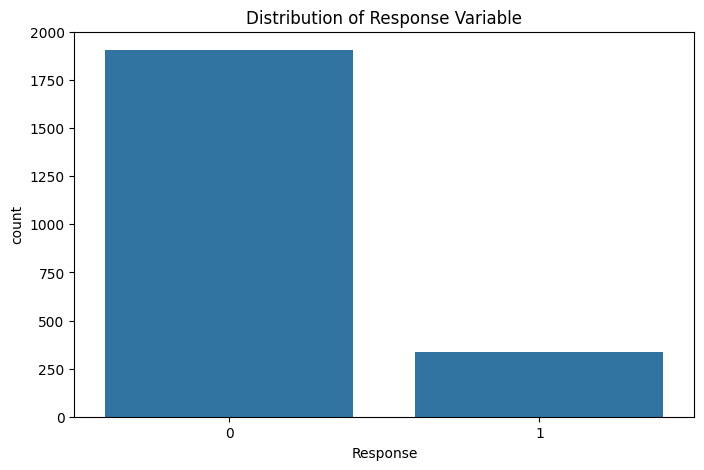

In [6]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 5))
sns.countplot(x='Response', data=df)
plt.title('Distribution of Response Variable')
plt.show()

In [7]:
# Step 4: Data Preprocessing
# Handle missing values (Income has some missing values)
df['Income'] = df['Income'].fillna(df['Income'].median())

In [8]:
# Feature engineering
# Calculate age from Year_Birth
df['Age'] = 2023 - df['Year_Birth']


In [9]:
# Calculate total children
df['Total_Children'] = df['Kidhome'] + df['Teenhome']


In [10]:
# Calculate customer tenure (days since enrollment)
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Tenure_Days'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days

In [11]:
 #Drop unnecessary columns
df = df.drop(['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue'], axis=1)

In [12]:
# Step 5: Define features and target
X = df.drop('Response', axis=1)
y = df['Response']


In [13]:
# Step 6: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [14]:
# Step 7: Preprocessing pipeline
# Identify categorical and numerical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

In [15]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [16]:
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [17]:
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [18]:
# Step 8: Model training and evaluation
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

In [19]:
# Train and evaluate each model
results = {}
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Evaluate model
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

    # Store results
    results[name] = {
        'model': pipeline,
        'accuracy': classification_report(y_test, y_pred, output_dict=True)['accuracy'],
        'roc_auc': roc_auc_score(y_test, y_prob)
    }



Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       381
           1       0.69      0.43      0.53        67

    accuracy                           0.89       448
   macro avg       0.80      0.70      0.73       448
weighted avg       0.87      0.89      0.87       448

ROC AUC Score: 0.8944

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       381
           1       0.85      0.33      0.47        67

    accuracy                           0.89       448
   macro avg       0.87      0.66      0.71       448
weighted avg       0.89      0.89      0.87       448

ROC AUC Score: 0.8920

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       381
           1       0.64      0.43      0.52        67

    accuracy                           0.88       448


In [20]:
# Step 9: Feature Importance Analysis (using the best model)
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
best_model = results[best_model_name]['model']

In [21]:
# Get feature names after one-hot encoding
preprocessor = best_model.named_steps['preprocessor']
feature_names = numerical_cols.copy()

# Add one-hot encoded feature names
ohe_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
feature_names.extend(ohe_features)

# Get feature importances
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    importances = best_model.named_steps['classifier'].feature_importances_
else:
    # For logistic regression, use absolute coefficients
    importances = np.abs(best_model.named_steps['classifier'].coef_[0])

# Create a DataFrame for feature importances
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

In [22]:
# Step 10: Business Insights
print("\nKey Business Insights:")
# 1. Response rate
response_rate = df['Response'].mean()
print(f"1. Overall response rate: {response_rate:.2%}")


Key Business Insights:
1. Overall response rate: 14.91%


In [23]:
# 2. Income vs response
print("\n2. Income analysis:")
print(df.groupby('Response')['Income'].describe())


2. Income analysis:
           count          mean           std     min       25%      50%  \
Response                                                                  
0         1906.0  50845.677597  25099.966955  1730.0  34560.00  50567.0   
1          334.0  60183.244012  23164.266112  7500.0  39786.75  64044.0   

              75%       max  
Response                     
0         65937.5  666666.0  
1         80477.0  105471.0  


In [26]:
# 4. Preferred purchase channels
print("\n4. Purchase channels comparison:")
channels = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
print(df.groupby('Response')[channels].mean())


4. Purchase channels comparison:
          NumWebPurchases  NumCatalogPurchases  NumStorePurchases
Response                                                         
0                3.911857             2.391920           5.736621
1                5.071856             4.203593           6.095808


In [27]:
# 5. Campaign acceptance
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
print("\n5. Campaign acceptance rates:")
print(df.groupby('Response')[campaigns].mean())


5. Campaign acceptance rates:
          AcceptedCmp1  AcceptedCmp2  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5
Response                                                                      
0             0.034103      0.005247      0.045121      0.055089      0.037251
1             0.236527      0.059880      0.230539      0.185629      0.275449
